## 5. Investigate the three terms of the reconstructed SD data

Packages

In [1]:
import pathlib
from pathlib import Path
import os 

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import cmocean as cmo
import scipy
from scipy import stats
import netCDF4
from netCDF4 import Dataset as nc
import cartopy.crs as ccrs
import matplotlib
import seaborn as sns

from AirSeaFluxCode import AirSeaFluxCode

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math

font = {'weight' : 'normal',
        'size'  : 20}
matplotlib.rc('font', **font)

Functions

In [2]:
import math
def wind_sp_kt_to_ms(wind_kts):
    
    return wind_kts*0.514444  #kt to m/s

def wind_sp_to_10m(wind_sp, z0=1.52e-4, zm=3.4, z10=10):
    
    """Correct wind speed data from a given height to 10m above sea level.

       wind_sp = wind speed measurement (m/s)
       z0      = roughness length
       zm      = height of wind measurement
       z10     = height to correct to
    """
    
    return wind_sp*(math.log(z10/z0)/math.log(zm/z0))

def wind_direction(v, u):
    DIR=90-np.rad2deg(np.arctan(v / u) )
    return DIR

from tqdm import tqdm  # Assuming you're using the tqdm library for progress tracking

def colocate_era5_sd(sd, era5, var):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.
    - var (str): The variable to be colocated.

    Returns:
    - era5_var (numpy.ndarray): An array of ERA5 variable values colocated with SD.
    """

    # Initialize an empty array to store ERA5 variable values
    era5_var = np.ndarray(sd.time.size)

    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        era5_var[t] = era5[var].isel(time=idx, latitude=lat_idx, longitude=lon_idx).data

    return era5_var

def era5dewtorh(era5_ds):
    # Extract dew point temperature (Dp) values from the input dataset
    Dp = era5_ds.d2m.values-273.15 # dew point temperature in celsius

    # Extract air temperature (T) values from the input dataset, and convert to celsius
    T = era5_ds.t2m.values # temperature in celsius
    
    # Calculate relative humidity (RH) using the formula and add it to the input dataset
    era5_ds['rh'] = (('time', 'latitude', 'longitude'),
                     100 * (np.exp((17.625 * Dp) / (243.04 + Dp)) / np.exp((17.625 * T) / (243.04 + T))))
    
    # Return the input dataset with the 'rh' variable added
    return era5_ds

def dist_era5_sd(sd, era5):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.

    Returns:
    - dist (numpy.ndarray): An array of distance in meters between nearest ERA5 gridpoint and SD.
    """

    # Initialize an empty array to store ERA5 variable values
    dist = np.ndarray(sd.time.size)
    #time = np.ndarray(sd.time.size)
    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        dist[t] = gsw.distance([era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['longitude'].data, sd.longitude[t]],[era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['latitude'].data, sd.latitude[t]]) 
        
        #dist[t]= (((era5.latitude[lat_idx]-sd.latitude[lat_idx])**2)+((era5.longitude[lon_idx]-sd.longitude[lon_idx])**2))**0.5
        #time[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['time']
        
        
    return dist

Load datasets

In [3]:
ds=xr.open_dataset( pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ds.nc')
ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ERA5file.nc')
coloc3=pd.read_csv(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc3.csv') 
dsadcpH=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/dsadcpH.nc')
ostia=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ostia.nc')
ERA5big=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5big.nc')

run ASFC

In [4]:
hum1=dsadcpH.rh.values

spd= coloc3.abs_rel.values#relative windpeed
SST= dsadcpH.sst.values
T= dsadcpH.t2m.values #seasurface temperature in kelvin. Will convert iff less than 200
hum= ['rh', hum1 ] #chose rh, spec hum or dew point temp.
P= dsadcpH.P_SEA.values #air pressure in hPA
SST_fl ='bulk' #string, 'bulk' or 'skin' for input
meth= 'C35' #string, choose method of calcultion
lat= dsadcpH.latitude.values #latitude
hin=([10, 2.3, 2.3])  #sensor heights in m, 3x1 same order as output 
hout=10 #output height, default is 10m
Rl=dsadcpH.dwlw.values#longwave dwn radiation
Rs= dsadcpH.dwsw.values # shortwave dwn radiation
cskin= 1 #0 cool skin adj off
skin='C35' #'C35' #string "C35", "ecmwf" or "Beljaars"
wl=1 #warm layer off 0 (default)
gust= None# [x,beta,zi,ustbj] #Check documentation
qmeth= 'Buck2' #string, saturation evaporation method
tol= None #float, tolerance limits for fluxes and heights, check documentation
maxiter= 30 #number fo iterations
out= 0 #int, set 0 to set points thathave not converged
out_var= None #str, define pandas arrayod variables for output. There i a default for cskin and gust off. Check documentation
L=None #str, M-O definition option. 'tsrv' is default

ASFC=AirSeaFluxCode(spd, T, SST, SST_fl, meth, lat=lat, hum=hum, P=P,
                   hin=hin, hout=hout, Rl=Rl, Rs=Rs, cskin=cskin, skin=skin, wl=wl,
                   gust=gust, qmeth=qmeth, tol=tol, maxiter=maxiter, out=out,
                   out_var=out_var, L=L)



Save ASFC SD to file so i is easy to work with while comparing with ERA5 later

In [5]:
ASFC.to_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD-ASFC.csv')

Create variables

In [6]:
u = ASFC.uref #ASFC['usr']/np.sqrt(ASFC['cd'])
t = ASFC['tsr']*np.sqrt(ASFC['cd'])/ASFC['ct']
rho = ASFC['rho']
cp = ASFC['cp']
ct = ASFC['ct']
lv = ASFC['lv']
q = ASFC['qsr']*np.sqrt(ASFC['cd'])/ASFC['cq']
cq= ASFC['cq']

u_mean = np.mean(u)
t_mean = np.mean(t)
q_mean = np.mean(q)

u_fluc = u - u_mean
t_fluc = t - t_mean
q_fluc = q - q_mean



Create mean and fluctuative terms

In [7]:
t_term = u_mean*t_fluc
u_term_t = t_mean*u_fluc
q_term = u_mean*q_fluc
u_term_q = q_mean*u_fluc

#lhf_coeffs=rho*cq*lv
#shf_coeffs=rho*cp*ct

lhf_coeffs=rho.mean()*cq.mean()*lv.mean()
shf_coeffs=rho.mean()*cp.mean()*ct.mean()

cov_term_q = u_fluc*q_fluc - np.mean(u_fluc*q_fluc)
cov_term_t = u_fluc*t_fluc - np.mean(u_fluc*t_fluc)

lhf_fluc = lhf_coeffs*(q_term + u_term_q + cov_term_q) 
shf_fluc = shf_coeffs*(t_term + u_term_t + cov_term_t) 

lhf_mean = np.zeros(len(q))+np.nanmean(q*u)*lhf_coeffs #np.mean(ASFC['latent'])
shf_mean = np.zeros(len(q))+np.nanmean(t*u)*shf_coeffs #np.mean(ASFC['sensible'])

lhf_recomposed = lhf_mean + lhf_fluc
shf_recomposed = shf_mean + shf_fluc

Create dataset with terms included in reconstructed fluxes

In [8]:
variables=['t_term', 'u_term_t', 'q_term', 'u_term_q','lhf_coeffs', 'shf_coeffs', 'cov_term_t', 'cov_term_q', 'lhf_fluc', 'shf_fluc', 'lhf_mean', 'shf_mean', 'lhf_recomposed','shf_recomposed' ]

reconstructed_ds=pd.DataFrame(columns=variables)

reconstructed_ds['t_term']=t_term
reconstructed_ds['u_term_t']=u_term_t
reconstructed_ds['q_term']=q_term
reconstructed_ds['u_term_q']=u_term_q
reconstructed_ds['lhf_coeffs']=lhf_coeffs
reconstructed_ds['shf_coeffs']=shf_coeffs
reconstructed_ds['cov_term_t']=cov_term_t
reconstructed_ds['cov_term_q']=cov_term_q
reconstructed_ds['lhf_fluc']=lhf_fluc
reconstructed_ds['shf_fluc']=shf_fluc
reconstructed_ds['lhf_mean']=lhf_mean
reconstructed_ds['shf_mean']=shf_mean
reconstructed_ds['lhf_recomposed']=lhf_recomposed
reconstructed_ds['shf_recomposed']=shf_recomposed

reconstructed_ds.to_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD-rec-THF.csv')

Corr plots

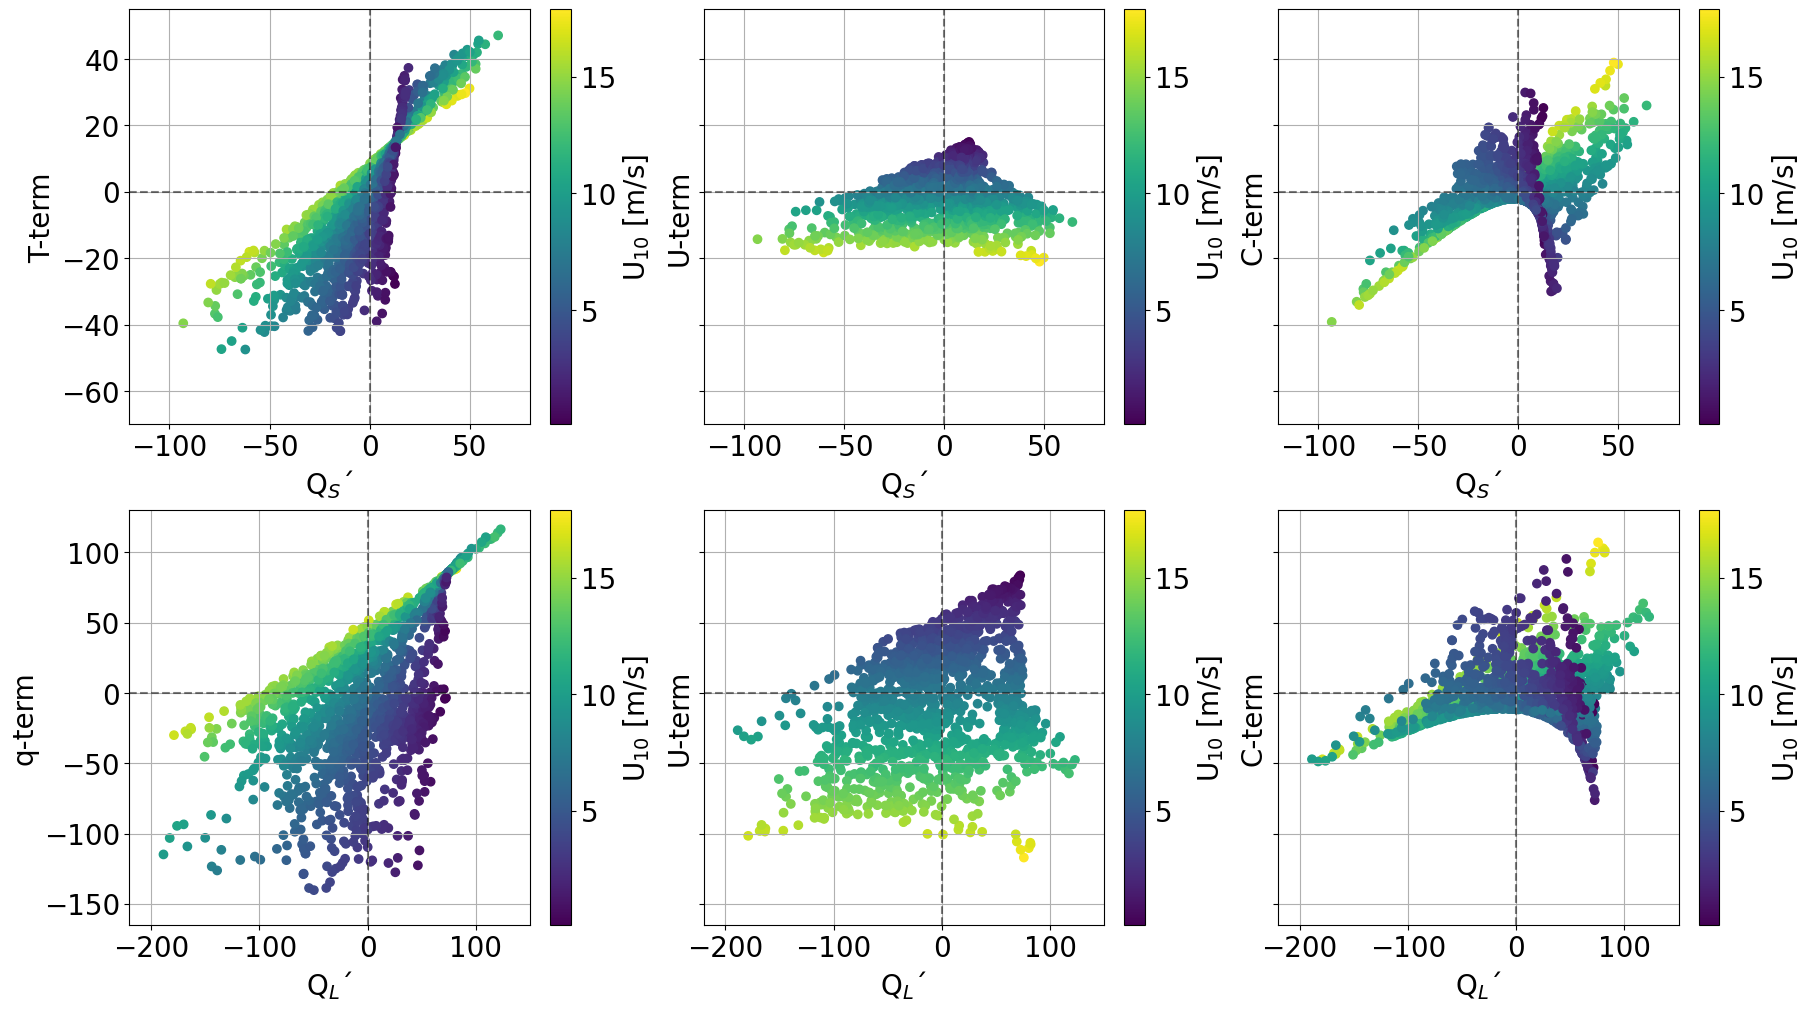

In [9]:
fig, ax=plt.subplots(2,3, figsize=[18,10], constrained_layout=True, sharex='row', sharey='row')

s_terms=[t_term, u_term_t, cov_term_t]
l_terms=[q_term, u_term_q, cov_term_q]

labelS = ['T-term', 'U-term', 'C-term']
labelL = ['q-term', 'U-term', 'C-term']

for i in np.arange(3):
    wind1=ax[0,i].scatter(shf_fluc, shf_coeffs*s_terms[i] , c=ASFC.uref)
    fig.colorbar(wind1, ax=ax[0,i], label=('U$_{10}$ [m/s]'))

    wind2=ax[1,i].scatter(lhf_fluc, lhf_coeffs*l_terms[i], c=ASFC.uref)
    fig.colorbar(wind2, ax=ax[1,i], label=('U$_{10}$ [m/s]'))
    
    ax[0,i].set_ylabel(labelS[i])
    ax[1,i].set_ylabel(labelL[i])
    
    ax[0,i].set_xlabel('Q$_S$´')
    ax[1,i].set_xlabel('Q$_L$´')

#    ax[0,i].set_xlim(-100, 60)
#    ax[1,i].set_xlim(-200, 150)

#    ax[0,i].set_ylim(-50, 50)
#    ax[1,i].set_ylim(-150, 125)
    ax[0,i].set_xlim(-120, 80)
    ax[1,i].set_xlim(-220, 150)

    ax[0,i].set_ylim(-70, 55)
    ax[1,i].set_ylim(-165, 130)
    
    ax[0,i].axvline(x=0, color='k', linestyle='--', alpha=0.5)
    ax[1,i].axvline(x=0, color='k', linestyle='--', alpha=0.5)

    ax[0,i].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax[1,i].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    
    ax[0,i].grid()
    ax[1,i].grid()
#    mask = ~np.isnan(varprime.Qs) & ~np.isnan(varprime.deltaT)

#    scipy.stats.linregress(varprime.Qs[mask], varprime.deltaT[mask])

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/figures/SDcorr.png')

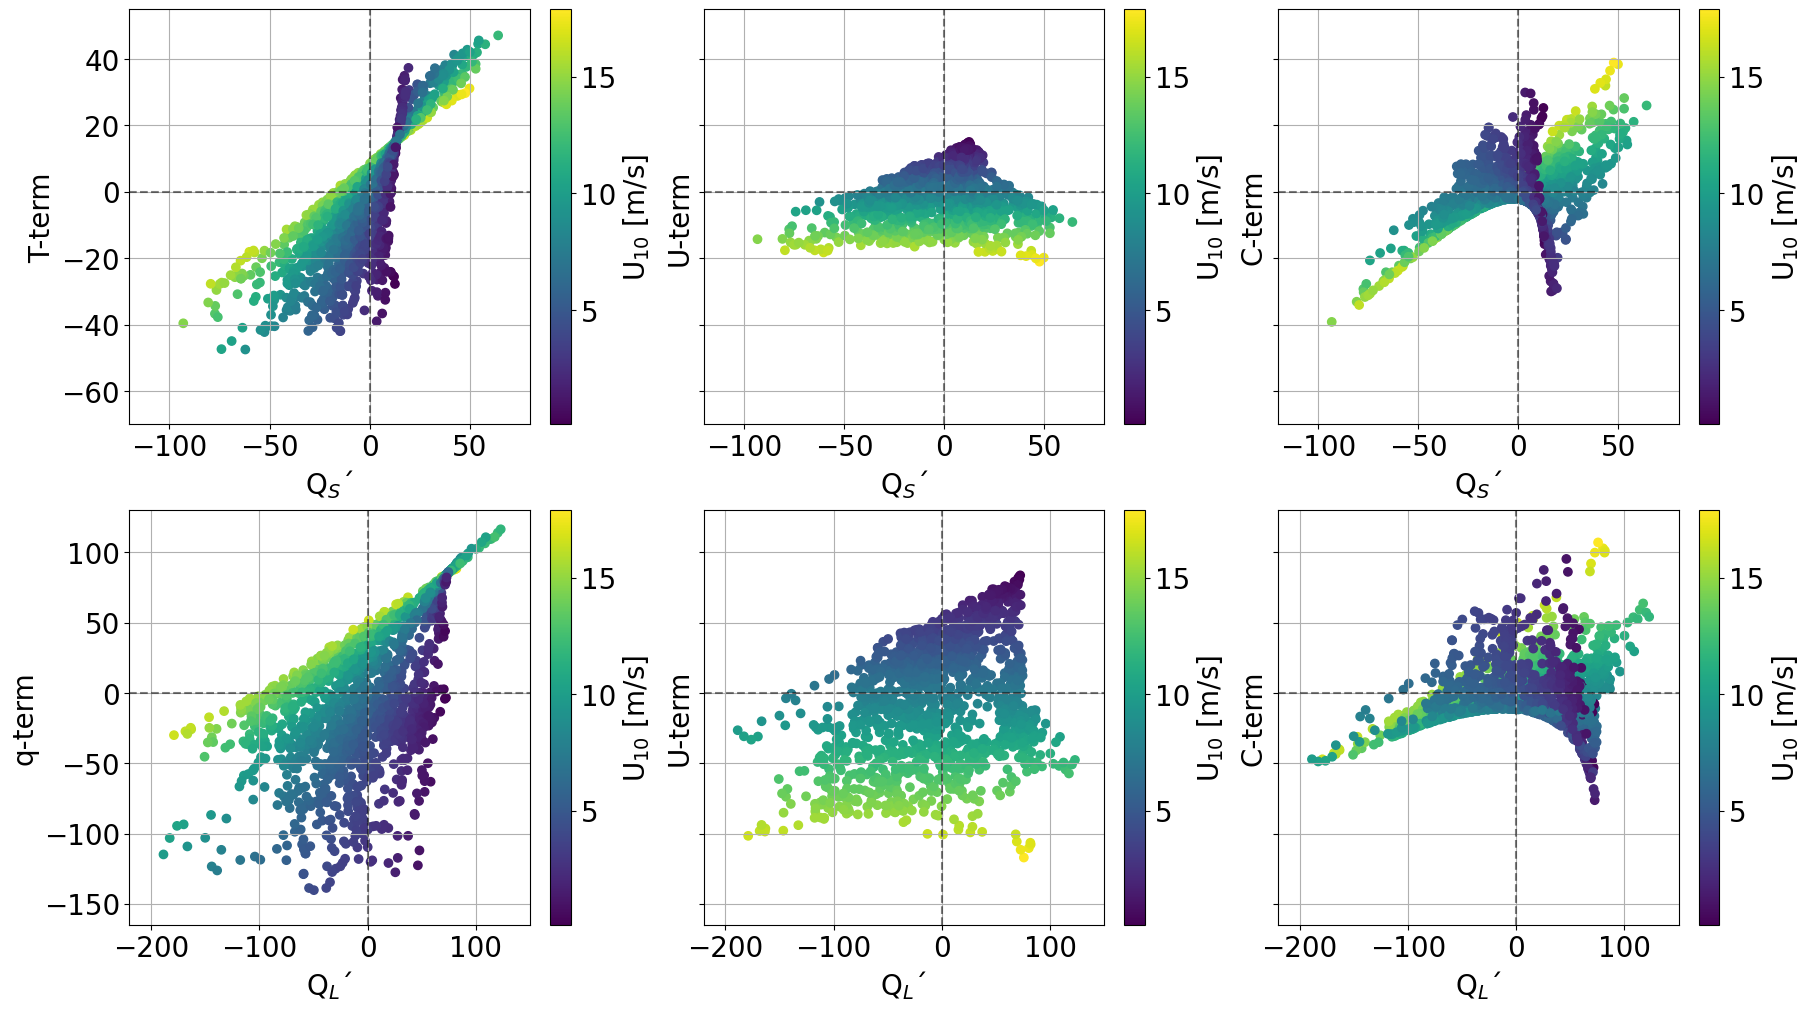

In [10]:
fig, ax=plt.subplots(2,3, figsize=[18,10], constrained_layout=True, sharex='row', sharey='row')

s_terms=[t_term, u_term_t, cov_term_t]
l_terms=[q_term, u_term_q, cov_term_q]

labelS = ['T-term', 'U-term', 'C-term']
labelL = ['q-term', 'U-term', 'C-term']

for i in np.arange(3):
    wind1=ax[0,i].scatter(shf_fluc, shf_coeffs*s_terms[i] , c=ASFC.uref)
    fig.colorbar(wind1, ax=ax[0,i], label=('U$_{10}$ [m/s]'))

    wind2=ax[1,i].scatter(lhf_fluc, lhf_coeffs*l_terms[i], c=ASFC.uref)
    fig.colorbar(wind2, ax=ax[1,i], label=('U$_{10}$ [m/s]'))
    
    ax[0,i].set_ylabel(labelS[i])
    ax[1,i].set_ylabel(labelL[i])
    
    ax[0,i].set_xlabel('Q$_S$´')
    ax[1,i].set_xlabel('Q$_L$´')

#    ax[0,i].set_xlim(-100, 60)
#    ax[1,i].set_xlim(-200, 150)

#    ax[0,i].set_ylim(-50, 50)
#    ax[1,i].set_ylim(-150, 125)
    ax[0,i].set_xlim(-120, 80)
    ax[1,i].set_xlim(-220, 150)

    ax[0,i].set_ylim(-70, 55)
    ax[1,i].set_ylim(-165, 130)
    
    ax[0,i].axvline(x=0, color='k', linestyle='--', alpha=0.5)
    ax[1,i].axvline(x=0, color='k', linestyle='--', alpha=0.5)

    ax[0,i].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax[1,i].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    
    ax[0,i].grid()
    ax[1,i].grid()

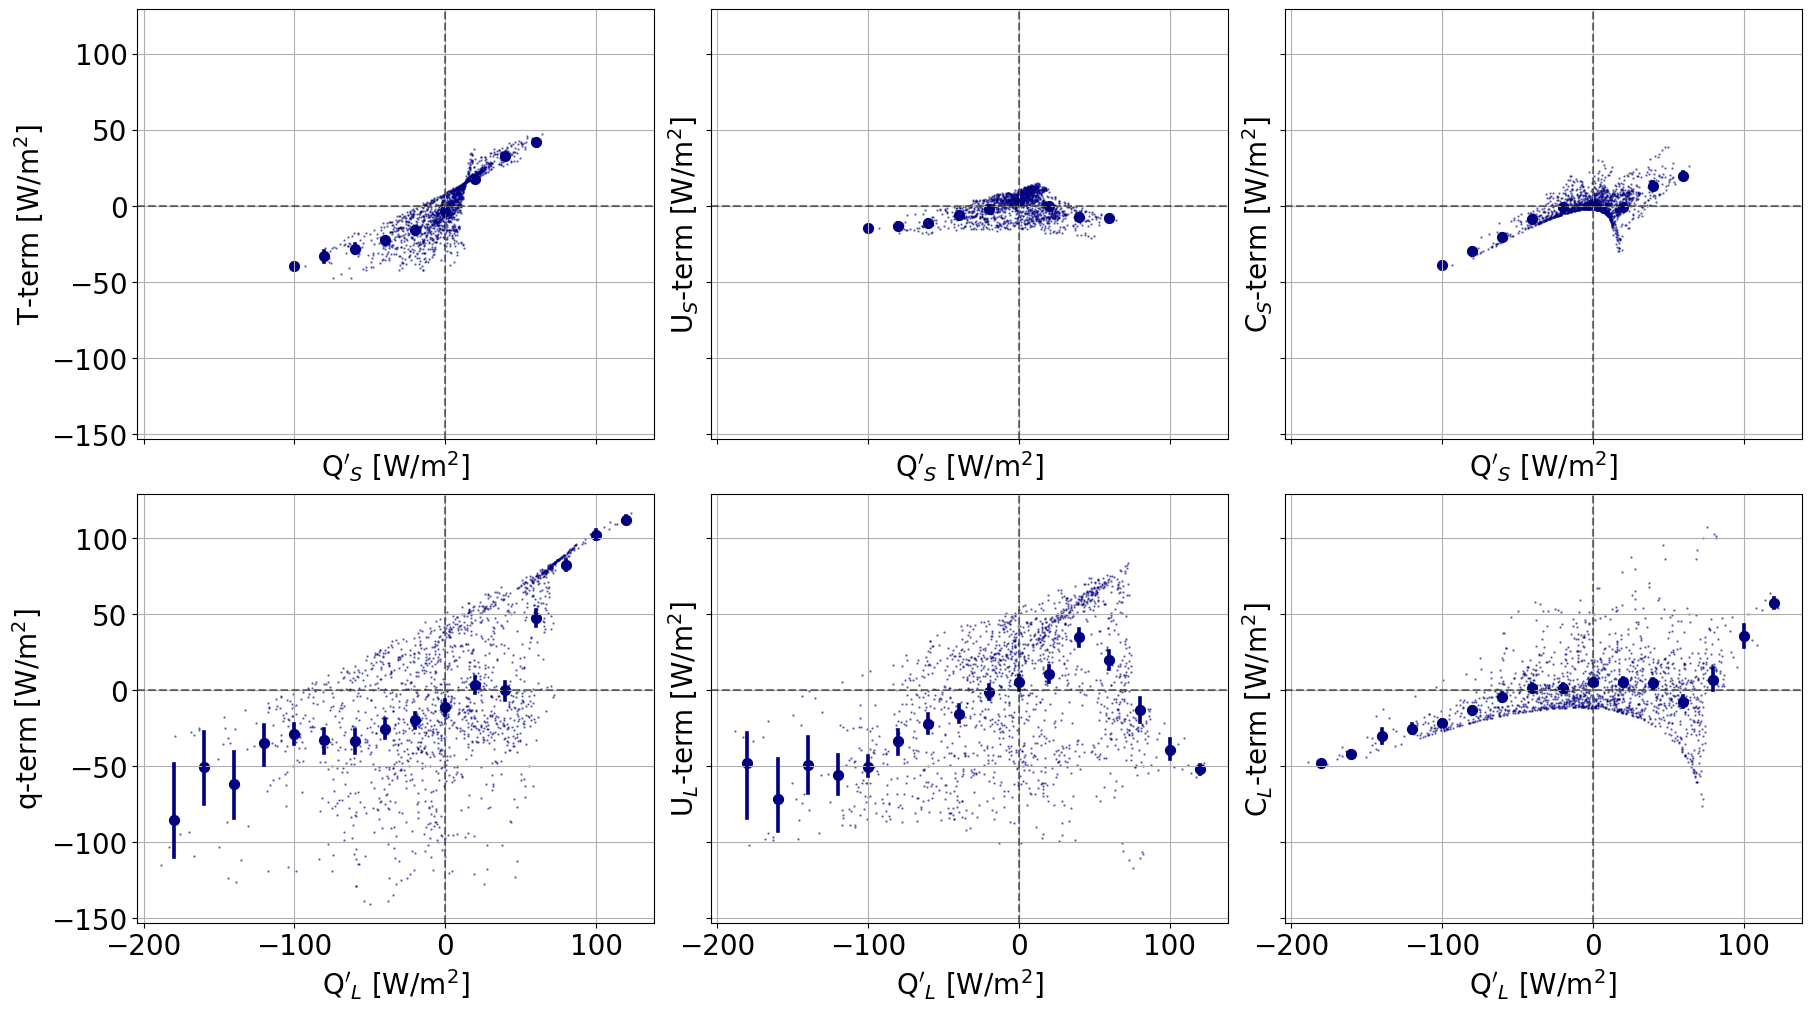

In [11]:
x_bins_s=np.arange(-100, 70, 20)
x_bins_l=np.arange(-200, 150, 20)

s_terms=[t_term, u_term_t, cov_term_t]
l_terms=[q_term, u_term_q, cov_term_q]

labelS = ['T-term', 'U$_S$-term', 'C$_S$-term']
labelL = ['q-term', 'U$_L$-term', 'C$_L$-term']



fig, ax=plt.subplots(2,3, figsize=[18,10], constrained_layout=True, sharex=True, sharey=True)
for i in np.arange(3):
    sns.regplot(x=shf_fluc, y=shf_coeffs*s_terms[i], x_bins=x_bins_s, ax=ax[0,i], fit_reg=False, color='navy')
    sns.regplot(x=shf_fluc, y=shf_coeffs*s_terms[i], x_bins=None, ax=ax[0,i], fit_reg=False, scatter_kws=dict(s=0.5,  color='navy', alpha=0.5))
    ax[0,i].set_ylabel(labelS[i] + ' [W/m$^2$]')
    ax[0,i].set_xlabel('Q$^\prime$$_S$ [W/m$^2$]')
    ax[0,i].grid()

    
    sns.regplot(x=lhf_fluc, y=lhf_coeffs*l_terms[i], x_bins=x_bins_l, ax=ax[1,i], fit_reg=False, color='navy')
    sns.regplot(x=lhf_fluc, y=lhf_coeffs*l_terms[i], x_bins=None, ax=ax[1,i], fit_reg=False, scatter_kws=dict(s=0.5,  color='navy', alpha=0.5))
    ax[1,i].set_ylabel(labelL[i]+ ' [W/m$^2$]')
    ax[1,i].grid()
    ax[1,i].set_xlabel('Q$^\prime$$_L$ [W/m$^2$]')
    
    ax[0,i].axvline(x=0, color='k', linestyle='--', alpha=0.5)
    ax[1,i].axvline(x=0, color='k', linestyle='--', alpha=0.5)

    ax[0,i].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax[1,i].axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/SD_terms_corr_v2.png')

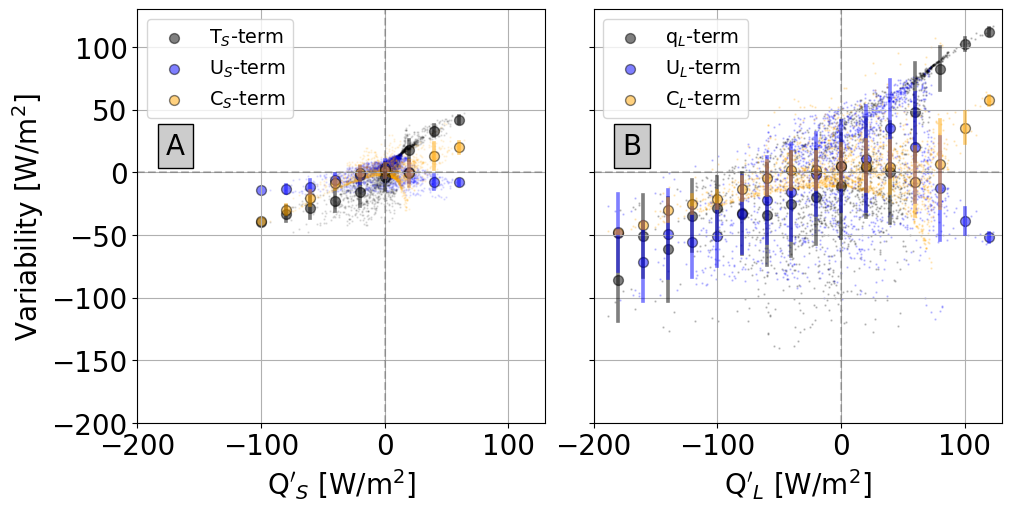

In [15]:

x_bins_s=np.arange(-100, 70, 20)
x_bins_l=np.arange(-200, 150, 20)

s_terms=[t_term, u_term_t, cov_term_t]
l_terms=[q_term, u_term_q, cov_term_q]

labelS = ['T$_S$-term', 'U$_S$-term', 'C$_S$-term']
labelL = ['q$_L$-term', 'U$_L$-term', 'C$_L$-term']

colors_s=['k', 'blue', 'orange']#['#1f4600', "#ff774c", "#b066dc"]
colors_l=['k', 'blue', 'orange']#["#3f316e", "#ff774c", "#b066dc"]

fig, ax=plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharex=True, sharey=True)

#Plot the tiny scatters first so they end up behind big scatterpoints
for i in np.arange(3):
    sns.regplot(x=shf_fluc, y=shf_coeffs*s_terms[i], x_bins=None, ax=ax[0], fit_reg=False, scatter_kws=dict(s=0.5,  color=colors_s[i], alpha=0.1))
    sns.regplot(x=lhf_fluc, y=lhf_coeffs*l_terms[i], x_bins=None, ax=ax[1], fit_reg=False, scatter_kws=dict(s=0.5,  color=colors_l[i], alpha=0.2))

#Plot mean scatters with std
for i in np.arange(3):
    sns.regplot(x=shf_fluc, y=shf_coeffs*s_terms[i], x_bins=x_bins_s, ax=ax[0], fit_reg=False, label=labelS[i], x_ci='sd', scatter_kws=dict(alpha=0.5, color=colors_s[i], edgecolors='k'))
    

    sns.regplot(x=lhf_fluc, y=lhf_coeffs*l_terms[i], x_bins=x_bins_l, ax=ax[1], fit_reg=False, label=labelL[i], x_ci='sd', scatter_kws=dict(alpha=0.5, color=colors_l[i], edgecolors='k'))
    
 
#    ax[1].set_ylabel(labelL[i])


ax[1].grid() 
ax[1].legend(fontsize='x-small', loc='upper left')


ax[0].axvline(x=0, color='k', linestyle='--', alpha=0.2)
ax[1].axvline(x=0, color='k', linestyle='--', alpha=0.2)

ax[0].axhline(y=0, color='k', linestyle='--', alpha=0.2)
ax[1].axhline(y=0, color='k', linestyle='--', alpha=0.2)

#    ax[0].set_ylabel(labelS[i])
ax[0].grid()
ax[0].legend(fontsize='x-small', loc='upper left')



ax[0].set_xlabel('Q$^\prime$$_S$ [W/m$^2$]')
ax[1].set_xlabel('Q$^\prime$$_L$ [W/m$^2$]')

ax[0].set_ylabel('Variability [W/m$^2$]')
#ax[1].set_ylabel('Term of variability [W/m$^2$]')


bbox = dict(boxstyle="square", fc="0.8")


ax[0].annotate('A', xy=(0.07,0.65), xycoords='axes fraction', bbox=bbox)
ax[1].annotate('B', xy=(0.07,0.65), xycoords='axes fraction', bbox=bbox)

low_lim=-200
top_lim=130

plt.xlim(low_lim,top_lim)

plt.ylim(low_lim,top_lim)

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/SD_terms_corr.png')

## Placeholder, some kind of normalisation on the terms based on the fluctuate flux based on the above figure

something like this would be good for actully quantifying the impact from the terms

# histograms

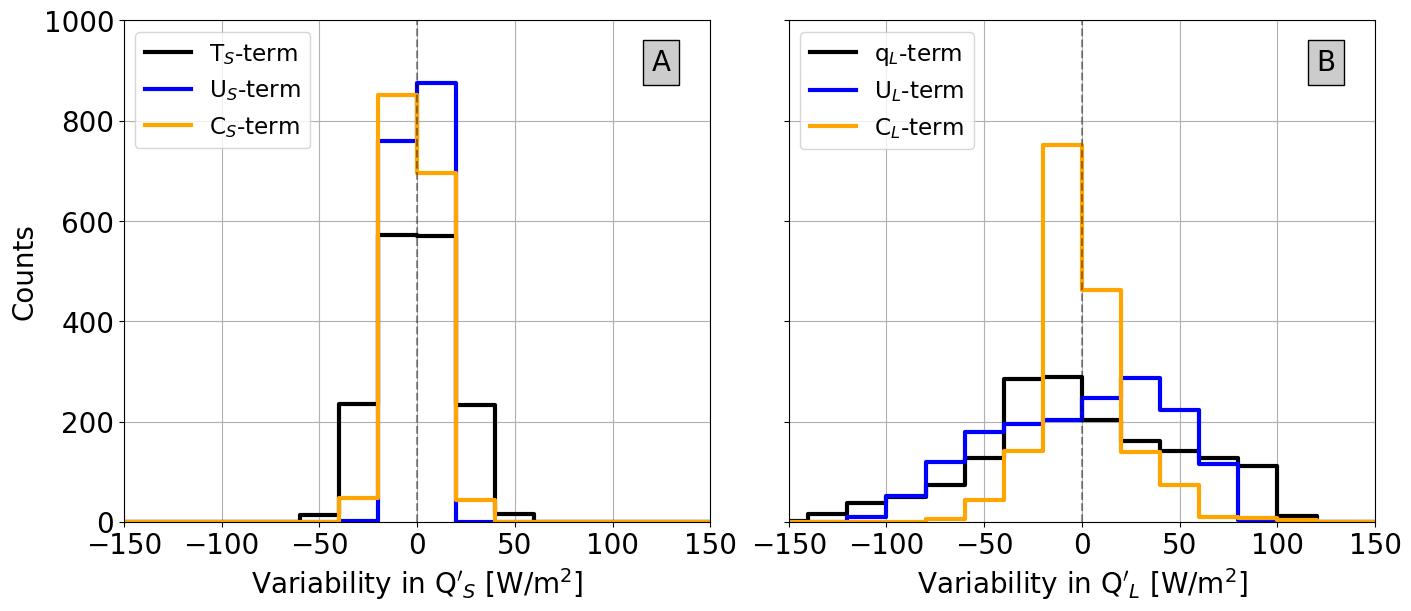

In [25]:
colors_s=['k', 'blue', 'orange']#['#1f4600', "#ff774c", "#b066dc"]
colors_l=['k', 'blue', 'orange']#["#3f316e", "#ff774c", "#b066dc"]

kde_setting=False
fill_setting=False

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1,2, figsize=[14, 6], constrained_layout=True, sharey=True)

# Lists defining keys for dictionaries
s_terms=[t_term, u_term_t, cov_term_t]
l_terms=[q_term, u_term_q, cov_term_q]

# Labels for the histograms
labelS = ['T$_S$-term', 'U$_S$-term', 'C$_S$-term']
labelL = ['q$_L$-term', 'U$_L$-term', 'C$_L$-term']

x_lbl=['Variability in Q$^\prime$$_S$ [W/m$^2$]','Variability in Q$^\prime$$_L$ [W/m$^2$]']

# Number of bins for the histograms
bins = np.arange(-200, 200, 20)

# Transparency of the histograms
alpha = 1

# Create histograms and add them to the subplots
for i in np.arange(3):
    sns.histplot(shf_coeffs*s_terms[i],bins=bins, label=labelS[i],kde=kde_setting, ax=ax[0], alpha=alpha, element="step", color=colors_s[i],fill=fill_setting, linewidth=3)
    sns.histplot(lhf_coeffs*l_terms[i], bins=bins, label=labelL[i],kde=kde_setting, ax=ax[1],alpha=alpha, element="step", color=colors_l[i], fill=fill_setting, linewidth=3)

# Customize the subplots
for i in np.arange(2):
    ax[i].grid()
    ax[i].legend(fontsize='small', loc='upper left')
    ax[i].set_xlabel(x_lbl[i])
    ax[i].set_ylabel('Counts')

    # Set titles for the subplots
#    ax[0].set_title('Q$_S$')
#    ax[1].set_title('Q$_L$')
    
    # Add a dashed vertical line at x = 0
    ax[i].axvline(x=0, color='k', linestyle='--', alpha=0.4)
    ax[i].set_ylim(0,1000)
    ax[i].set_xlim(-150,150) 

bbox = dict(boxstyle="square", fc="0.8")


ax[0].annotate('A', xy=(0.9,0.9), xycoords='axes fraction', bbox=bbox)
ax[1].annotate('B', xy=(0.9,0.9), xycoords='axes fraction', bbox=bbox)
   
# Display the plot
plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/SD_hist.png')

In [58]:
s_terms[i]

0      -6.329568
1      -4.498804
2      -4.308532
3      -5.529958
4      -6.159800
          ...   
1633    7.309010
1634    6.050690
1635    4.695822
1636    4.549014
1637    4.015431
Name: uref, Length: 1638, dtype: float64

Create array with terms and absolute variability variables

In [14]:
s_terms=[t_term, u_term_t, cov_term_t]
l_terms=[q_term, u_term_q, cov_term_q]

mag_shf_var= shf_coeffs*(np.abs(t_term)+np.abs(u_term_t)+np.abs(cov_term_t)) 
mag_lhf_var=lhf_coeffs*(np.abs(q_term)+np.abs(u_term_q)+np.abs(cov_term_q)) 

In [24]:
mag_shf_var

0       14.887495
1        9.826769
2       12.128768
3       21.394099
4       25.651775
          ...    
1633    14.706143
1634    14.875177
1635    15.036457
1636    17.709530
1637    19.880898
Length: 1638, dtype: float64

Colormap

In [15]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# SHF

Only SHF stacked histograms with percentage of variability

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1637/1637 [00:05<00:00, 302.30it/s]


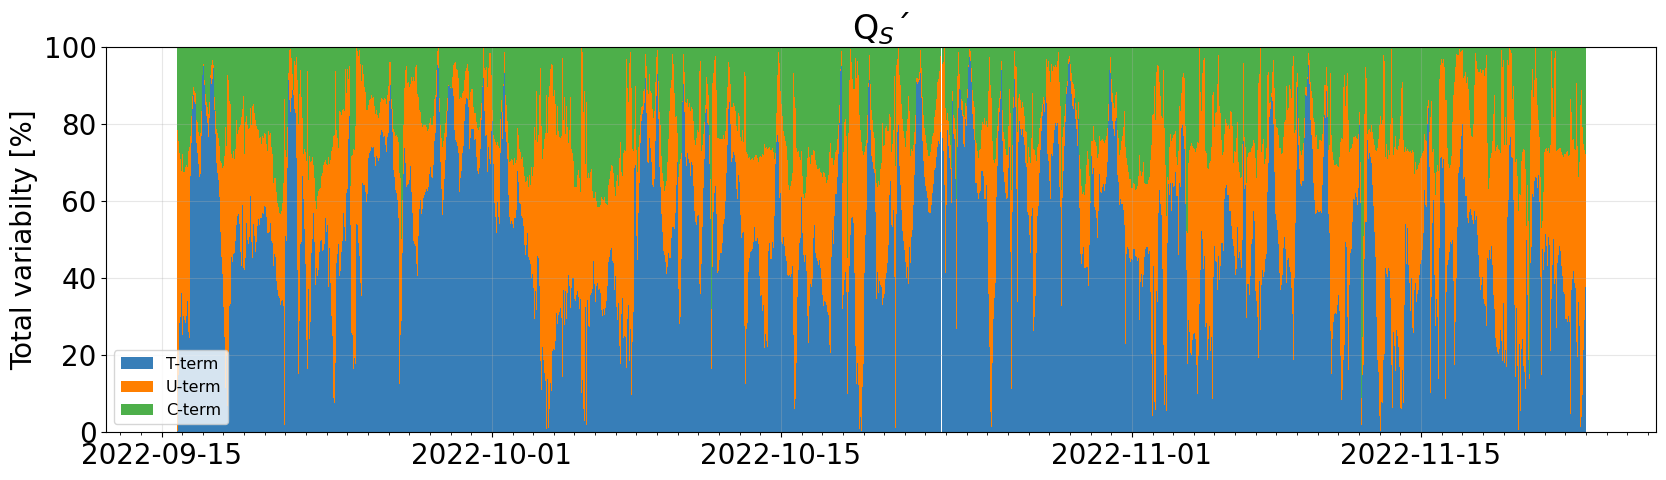

In [18]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']


fig,ax = plt.subplots(figsize=(20,5), sharex=True)

for t in tqdm(np.arange(len(dsadcpH.time)-1)):
    y1_list=[]
    for i in np.arange(3):
        y1=shf_coeffs*np.abs(s_terms[i][t])/mag_shf_var[t]*100
        
        ax.bar(dsadcpH.time[t], y1, bottom=np.sum(y1_list), color=CB_color_cycle[i],width=pd.Timedelta(hours=1))
        y1_list.append(y1)
        
y1_list=[]        
for i in np.arange(3):
        y1=(shf_coeffs*np.abs(s_terms[i][1637])/mag_shf_var[1637])*100
        
        ax.bar(dsadcpH.time[1637], y1, bottom=np.sum(y1_list), color=CB_color_cycle[i],width=pd.Timedelta(hours=1), label=labelS[i])
        y1_list.append(y1)        
        
        
ax.legend(fontsize='xx-small', loc='lower left')
ax.set_ylabel('Total variabilty [%]')
ax.set_title('Q$_S$´')
ax.set_ylim(0,100)
#ax[0].set_xlim(dsadcpH.time.min(), dsadcpH.time.max())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(alpha=0.3)



Stacked barplots with absolute variability and absolute variabilty

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1637/1637 [00:05<00:00, 294.69it/s]


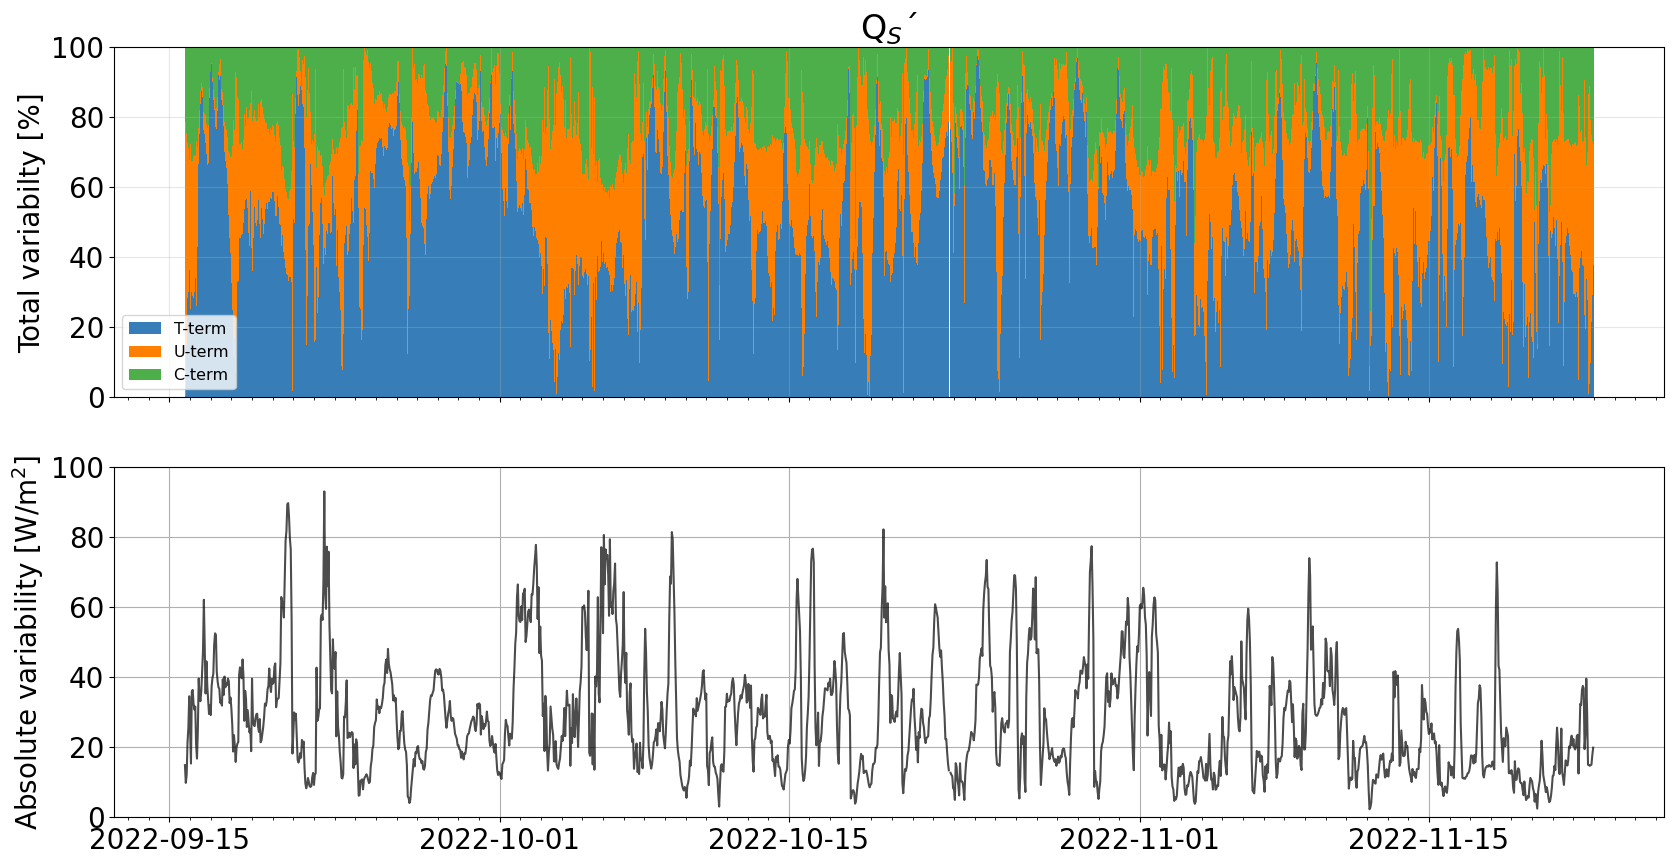

In [25]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']


fig,ax = plt.subplots(2,1, figsize=(20,10), sharex=True)

for t in tqdm(np.arange(len(dsadcpH.time)-1)):
    y1_list=[]
    for i in np.arange(3):
        y1=shf_coeffs*np.abs(s_terms[i][t])/mag_shf_var[t]*100
        
        ax[0].bar(dsadcpH.time[t], y1, bottom=np.sum(y1_list), color=CB_color_cycle[i],width=pd.Timedelta(hours=1))
        y1_list.append(y1)
        
y1_list=[]        
for i in np.arange(3):
        y1=(shf_coeffs*np.abs(s_terms[i][1637])/mag_shf_var[1637])*100
        
        ax[0].bar(dsadcpH.time[1637], y1, bottom=np.sum(y1_list), color=CB_color_cycle[i],width=pd.Timedelta(hours=1), label=labelS[i])
        y1_list.append(y1)        
        
        
ax[0].legend(fontsize='xx-small', loc='lower left')
ax[0].set_ylabel('Total variabilty [%]')
ax[0].set_title('Q$_S$´')
ax[0].set_ylim(0,100)
#ax[0].set_xlim(dsadcpH.time.min(), dsadcpH.time.max())

ax[0].grid(alpha=0.3)

ax[1].plot(dsadcpH.time, mag_shf_var, c='k', alpha=0.7)
ax[1].set_ylabel('Absolute variability [W/m$^2$]')
ax[1].grid()
ax[1].set_ylim(0,100)

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/figures/SDbarplotQS.png')

# LHF

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1637/1637 [00:05<00:00, 303.25it/s]


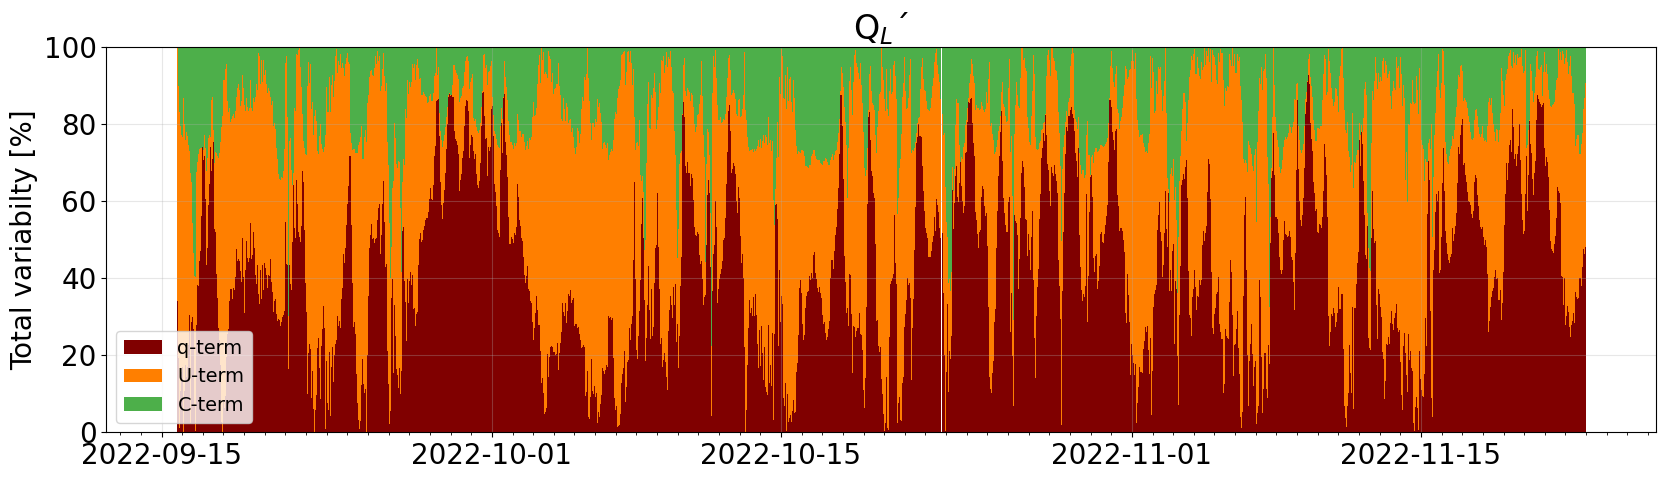

In [26]:
CB_color_cycle = ['maroon', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

fig,ax = plt.subplots(figsize=(20,5), sharex=True)

for t in tqdm(np.arange(len(dsadcpH.time)-1)):
    y1_list=[]
    for i in np.arange(3):
        y1=lhf_coeffs*np.abs(l_terms[i][t])/mag_lhf_var[t]*100
        
        ax.bar(dsadcpH.time[t], y1, bottom=np.sum(y1_list), color=CB_color_cycle[i],width=pd.Timedelta(hours=1))
        y1_list.append(y1)
        
y1_list=[]        
for i in np.arange(3):
        y1=(lhf_coeffs*np.abs(l_terms[i][1637])/mag_lhf_var[1637])*100
        
        ax.bar(dsadcpH.time[1637], y1, bottom=np.sum(y1_list), color=CB_color_cycle[i],width=pd.Timedelta(hours=1), label=labelL[i])
        y1_list.append(y1)        
        
        
ax.legend(fontsize='x-small', loc='lower left')
ax.set_ylabel('Total variabilty [%]')
ax.set_title('Q$_L$´')
ax.set_ylim(0,100)
#ax[0].set_xlim(dsadcpH.time.min(), dsadcpH.time.max())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(alpha=0.3)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1637/1637 [00:05<00:00, 301.11it/s]


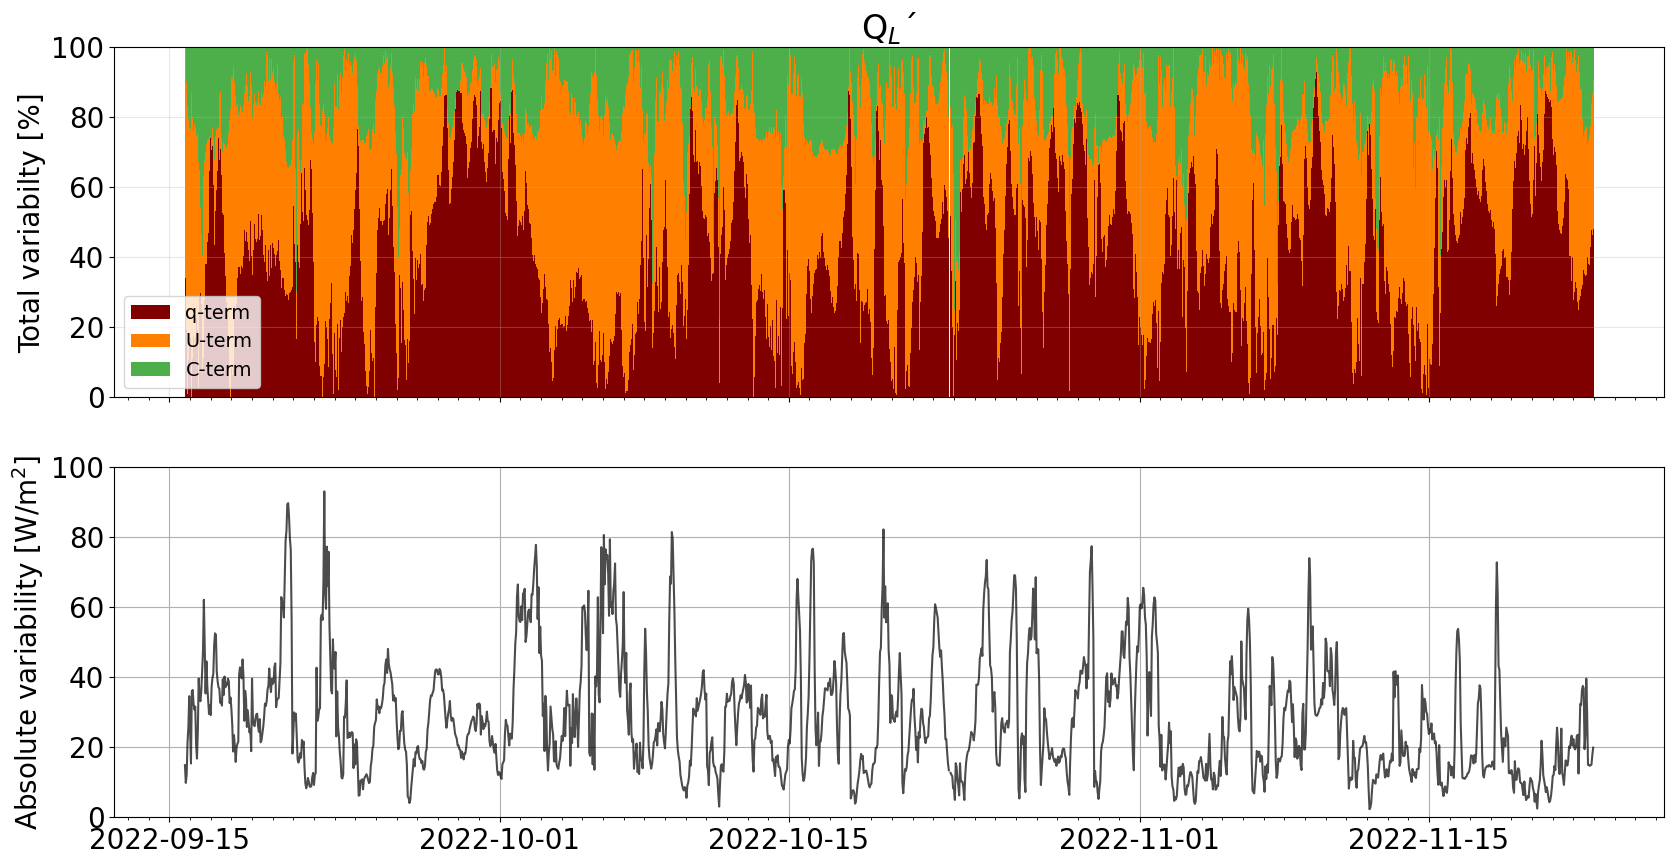

In [27]:
CB_color_cycle = ['maroon', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

fig,ax = plt.subplots(2,1, figsize=(20,10), sharex=True)

for t in tqdm(np.arange(len(dsadcpH.time)-1)):
    y1_list=[]
    for i in np.arange(3):
        y1=lhf_coeffs*np.abs(l_terms[i][t])/mag_lhf_var[t]*100
        
        ax[0].bar(dsadcpH.time[t], y1, bottom=np.sum(y1_list), color=CB_color_cycle[i],width=pd.Timedelta(hours=1))
        y1_list.append(y1)
        
y1_list=[]        
for i in np.arange(3):
        y1=(lhf_coeffs*np.abs(l_terms[i][1637])/mag_lhf_var[1637])*100
        
        ax[0].bar(dsadcpH.time[1637], y1, bottom=np.sum(y1_list), color=CB_color_cycle[i],width=pd.Timedelta(hours=1), label=labelL[i])
        y1_list.append(y1)        
        
        
ax[0].legend(fontsize='x-small', loc='lower left')
ax[0].set_ylabel('Total variabilty [%]')
ax[0].set_title('Q$_L$´')
ax[0].set_ylim(0,100)
#ax[0].set_xlim(dsadcpH.time.min(), dsadcpH.time.max())
ax[0].xaxis.set_minor_locator(mdates.DayLocator())
ax[0].grid(alpha=0.3)

ax[1].plot(dsadcpH.time, mag_shf_var, c='k', alpha=0.7)
ax[1].set_ylabel('Absolute variability [W/m$^2$]')
ax[1].grid()
ax[1].set_ylim(0,100)

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/figures/SDbarplotQL.png')

Next task: Add legend to above, set labels and fix colors.

use ASFC on ERA5 data, corr plots between terms of SD reconstructed and ERA5 recnstructed fluxes. coloc3 dataset

--> UPSCALE